/var/folders/d9/60nxsm7s7tl4lft6pwrfpjfm0000gn/T/ipykernel_89089/3174465845.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df[cols].interpolate().fillna(method="bfill").fillna(method="ffill")


R2 Score: 0.16340060255238598


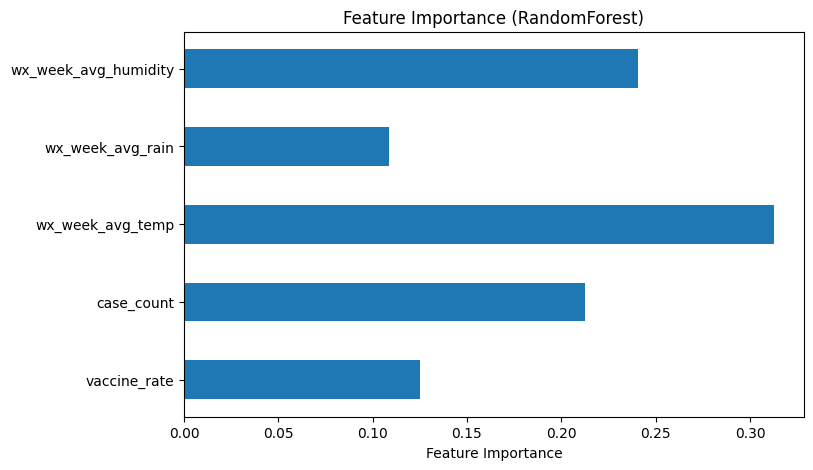

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# ===== 1. 데이터 로드 =====
df = pd.read_csv("data/raw/merge_data.csv")

cols = ["ili","vaccine_rate","case_count",
        "wx_week_avg_temp","wx_week_avg_rain","wx_week_avg_humidity"]

df = df[cols].interpolate().fillna(method="bfill").fillna(method="ffill")

# ===== 2. Feature / Target =====
X = df.drop(columns=["ili"])
y = df["ili"]

# ===== 3. Train / Test Split =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== 4. Random Forest 학습 =====
model = RandomForestRegressor(
    n_estimators=500,
    random_state=42
)

model.fit(X_train, y_train)

# ===== 5. 예측 성능 =====
pred = model.predict(X_test)
print("R2 Score:", r2_score(y_test, pred))

# ===== 6. Feature Importance 시각화 =====
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8,5))
plt.barh(feature_names, importances, height=0.5)
plt.xlabel("Feature Importance")
plt.title("Feature Importance (RandomForest)")
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv("data/raw/merge_data.csv")

# 필요한 컬럼만 선택
cols = ["ili","vaccine_rate","case_count",
        "wx_week_avg_temp","wx_week_avg_rain","wx_week_avg_humidity"]

# 결측 처리
df = df[cols].interpolate().fillna(method="bfill").fillna(method="ffill")

# 상관계수 행렬
corr = df.corr(method="pearson")
print(corr)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Pearson)")
plt.show()

                           ili  vaccine_rate  case_count  wx_week_avg_temp  \
ili                   1.000000     -0.038011   -0.112767          0.276454   
vaccine_rate         -0.038011      1.000000    0.046034         -0.011006   
case_count           -0.112767      0.046034    1.000000         -0.451780   
wx_week_avg_temp      0.276454     -0.011006   -0.451780          1.000000   
wx_week_avg_rain      0.081983     -0.099509   -0.150686          0.389912   
wx_week_avg_humidity -0.072202     -0.244563   -0.276756          0.530214   

                      wx_week_avg_rain  wx_week_avg_humidity  
ili                           0.081983             -0.072202  
vaccine_rate                 -0.099509             -0.244563  
case_count                   -0.150686             -0.276756  
wx_week_avg_temp              0.389912              0.530214  
wx_week_avg_rain              1.000000              0.491149  
wx_week_avg_humidity          0.491149              1.000000  


/var/folders/d9/60nxsm7s7tl4lft6pwrfpjfm0000gn/T/ipykernel_89089/4246780711.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df[cols].interpolate().fillna(method="bfill").fillna(method="ffill")


ModuleNotFoundError: No module named 'seaborn'

Using CSV: 3_merged_influenza_vaccine_respiratory_weather.csv | Device: cuda
USE_EXOG = 'all'  (auto-detects vaccine/resp columns)
[Data] Exogenous detected -> vaccine_rate: True | respiratory_index: True | climate_feats: ['wx_week_avg_temp', 'wx_week_avg_rain', 'wx_week_avg_humidity']
[Data] Selected feature columns (order) -> ['ili', 'vaccine_rate', 'respiratory_index', 'wx_week_avg_temp', 'wx_week_avg_rain', 'wx_week_avg_humidity', 'week_sin', 'week_cos']
Data points: 3648 | Features used (8): ['ili', 'vaccine_rate', 'respiratory_index', 'wx_week_avg_temp', 'wx_week_avg_rain', 'wx_week_avg_humidity', 'week_sin', 'week_cos']
[Shapes] X_tr:(2553, 8), X_va:(547, 8), X_te:(548, 8) | F=8
[Info] Model input feature order -> ['ili', 'vaccine_rate', 'respiratory_index', 'wx_week_avg_temp', 'wx_week_avg_rain', 'wx_week_avg_humidity', 'week_sin', 'week_cos']
[Batch] Xb.shape=(64, 9, 4, 8) (B,P,L,F), yb.shape=(64, 3)
[Batch] Feature order used -> ['ili', 'vaccine_rate', 'respiratory_index', 'w

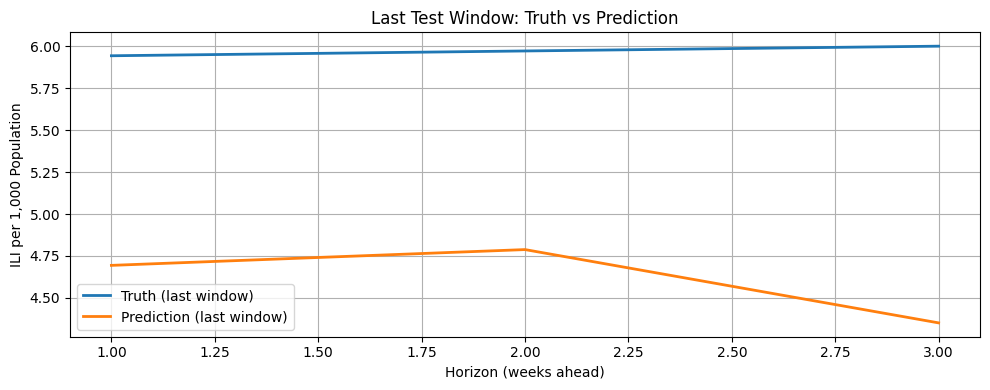

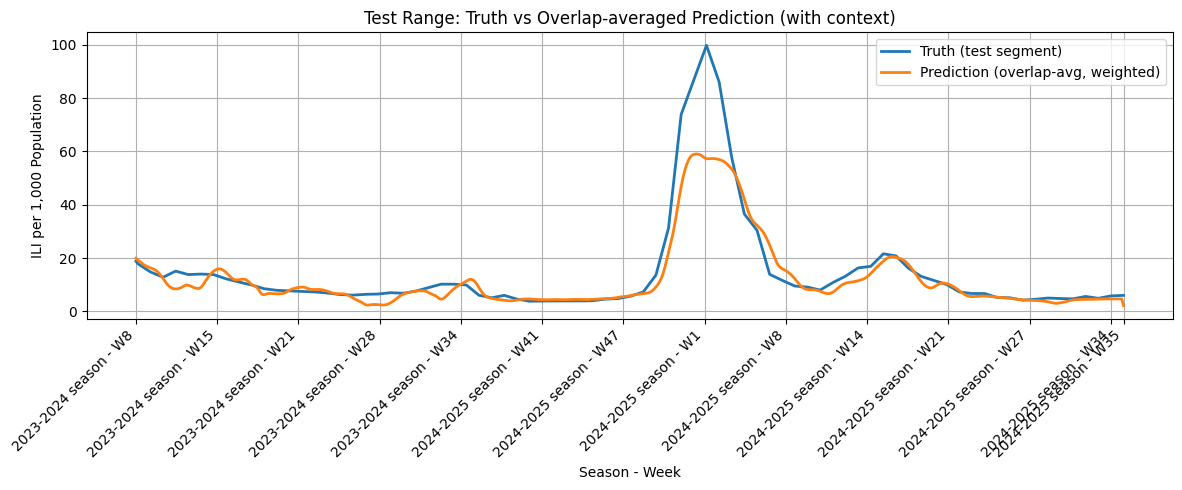

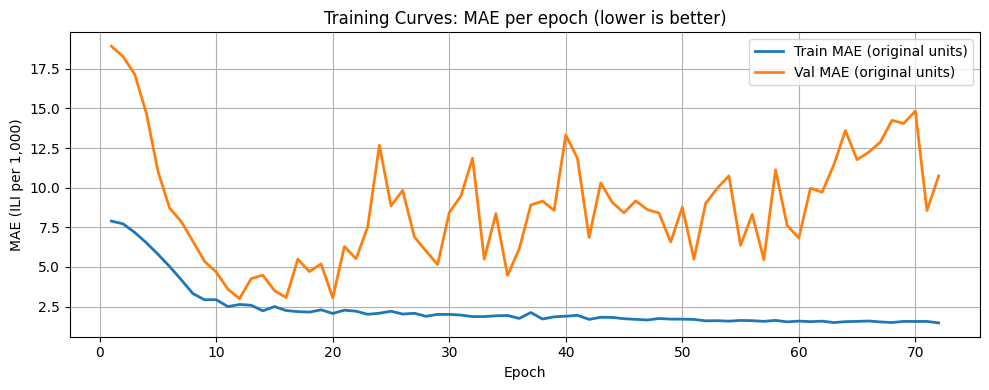

In [ ]:
# ili_patchtst_train_and_plot_v4_cnnmix.py
# -*- coding: utf-8 -*-
"""
Influenza ILI forecasting with PatchTST (multivariate-ready) + Multi-Scale CNN Patching
- CSV: merged_influenza_vaccine_respiratory_filled.csv (fallbacks supported)
- Auto-detect columns: 'ili' (target), 'vaccine_rate', 'respiratory_index'
- Exogenous features selectable: USE_EXOG = 'auto'|'none'|'vax'|'resp'|'both'
- Train-only scaling: separate scaler_y (target) and scaler_x (features)
- **Multi-Scale CNN Patch Embedding + TokenConvMixer → PatchTST-style encoder + Attention Pooling**
- Loss: Huber; Optim: AdamW; Cosine LR + warmup; EarlyStopping
- Saves: predictions CSV, last-window plot, test reconstruction, MAE curves
"""

import math
from pathlib import Path
from typing import List, Tuple, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# =========================
# Paths & device
# =========================
BASE_DIR = Path.cwd()
# 우선순위로 탐색 (새 파일 -> 구 파일들)
CANDIDATE_CSVS = [
    BASE_DIR / "data/processed/3_merged_influenza_vaccine_respiratory_weather_filled.csv",
    BASE_DIR / "data/processed/3_merged_influenza_vaccine_respiratory_weather.csv",
]
def pick_csv_path():
    for p in CANDIDATE_CSVS:
        if p.exists():
            return p
    raise FileNotFoundError("No input CSV found among:\n" + "\n".join(map(str, CANDIDATE_CSVS)))

CSV_PATH = pick_csv_path()

def pick_device():
    if torch.cuda.is_available():
        return "cuda"
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return "mps"
    return "cpu"

DEVICE = pick_device()
SEED   = 42

# =========================
# Hyperparameters
# =========================
EPOCHS      = 100
BATCH_SIZE  = 64        # 소규모 시계열에서도 안정적으로 학습되도록 약간 낮춤
SEQ_LEN     = 12
PRED_LEN    = 3
PATCH_LEN   = 4          # ← CNN이 최소 3~5 커널 적용 가능하도록 확대
STRIDE      = 1

D_MODEL     = 128        # 4의 배수(멀티스케일 분기 4개 합산)
N_HEADS     = 2
ENC_LAYERS  = 4
FF_DIM      = 128
DROPOUT     = 0.3        # 약간 강화
HEAD_HIDDEN = [64, 64]

LR              = 5e-4
WEIGHT_DECAY    = 5e-4
PATIENCE        = 60
WARMUP_EPOCHS   = 30

SCALER_TYPE     = "robust"   # 노이즈/꼬리값 대응에 유리 (원하면 "standard"로 변경)

# 외생 특징 사용 모드: "auto"|"none"|"vax"|"resp"|"both"
USE_EXOG        = "all"

OUT_CSV          = str(BASE_DIR / "data/results/ili_predictions.csv")
PLOT_LAST_WINDOW = str(BASE_DIR / "plot_last_window.png")
PLOT_TEST_RECON  = str(BASE_DIR / "plot_test_reconstruction.png")
PLOT_MA_CURVES   = str(BASE_DIR / "plot_ma_curves.png")

# overlap 재구성 가중치 (t+1을 조금 더 신뢰)
RECON_W_START, RECON_W_END = 2.0, 0.5

# --- Feature switches ---
INCLUDE_SEASONAL_FEATS = True   # week_sin, week_cos를 입력 피처에 포함할지

# =========================
# utils
# =========================
from datetime import date

def _iso_weeks_in_year(y: int) -> int:
    # ISO 달력의 마지막 주 번호(52 또는 53)
    return date(y, 12, 28).isocalendar().week

def weekly_to_daily_interp(
    df: pd.DataFrame,
    season_col: str = "season_norm",
    week_col: str = "week",
    target_col: str = "ili",
) -> pd.DataFrame:
    """
    주 단위 데이터를 일 단위로 확장(선형보간). season/week 없으면 label에서 추출하거나,
    최후에는 연속 주차를 생성해 보간합니다.
    반환: date 컬럼 포함한 일 단위 DF
    """
    df = df.copy()
    df.columns = df.columns.str.replace("\ufeff", "", regex=True).str.strip()

    # --- 시즌/주차 확보 ---
    has_season = season_col in df.columns
    has_week   = week_col in df.columns

    if not (has_season and has_week):
        # label에서 시즌/주차 추출 시도: "2024-2025 season - W29"
        if "label" in df.columns:
            import re
            def _parse_label(lbl):
                m = re.search(r"(\d{4}-\d{4}).*W\s*([0-9]+)", str(lbl))
                if m:
                    return m.group(1), int(m.group(2))
                return None
            parsed = df["label"].map(_parse_label)
            if not has_season:
                df[season_col] = [p[0] if p else np.nan for p in parsed]
                has_season = True
            if not has_week:
                df[week_col] = [p[1] if p else np.nan for p in parsed]
                has_week = True

    # 최후의 수단: season_norm이 없으면 단일 시즌으로, week 없으면 1..N
    if not has_season:
        # 첫 행의 연도를 찾아 대체 시즌명 만들기
        # 없으면 "0000-0001"
        first_year = None
        if "date" in df.columns:
            try:
                first_year = pd.to_datetime(df["date"]).dt.year.min()
            except Exception:
                pass
        if first_year is None:
            first_year = pd.Timestamp.today().year
        df[season_col] = f"{first_year}-{first_year+1}"
        has_season = True

    if not has_week:
        df[week_col] = np.arange(1, len(df) + 1, dtype=int)
        has_week = True

    # 숫자화
    df[week_col] = pd.to_numeric(df[week_col], errors="coerce")
    # 시즌 문자열 정규화
    def _norm_season_text_local(s: str) -> str:
        ss = str(s).replace("절기", "")
        import re
        m = re.search(r"(\d{4})\s*-\s*(\d{4})", ss)
        return f"{m.group(1)}-{m.group(2)}" if m else ss.strip()
    df[season_col] = df[season_col].astype(str).map(_norm_season_text_local)

    # --- ISO 주 시작일 산출 (시즌 규칙 반영) ---
    week_starts = []
    for _, row in df.iterrows():
        season = str(row[season_col])
        try:
            y0 = int(season.split("-")[0])
        except Exception:
            y0 = pd.Timestamp.today().year
        wk = int(row[week_col]) if not pd.isna(row[week_col]) else 1
        iso_year = y0 if wk >= 36 else (y0 + 1)
        # 해당 ISO년의 실제 마지막 주 넘지 않도록 보정
        wk = min(max(1, wk), _iso_weeks_in_year(iso_year))
        # 월요일(1) 기준 주 시작일
        week_starts.append(pd.Timestamp.fromisocalendar(iso_year, wk, 1))
    df["week_start"] = week_starts

    # --- 중복 week_start 처리: 수치=mean, 비수치=first ---
    if df["week_start"].duplicated().any():
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        agg = {c: "mean" for c in num_cols}
        # 비수치 컬럼(라벨/시즌 등)은 첫 값 유지
        for c in df.columns:
            if c not in num_cols and c != "week_start":
                agg[c] = "first"
        df = df.groupby("week_start", as_index=False).agg(agg)

    # --- 일 단위 리샘플 ---
    df = df.set_index("week_start").sort_index()
    df_daily = df.resample("D").asfreq()

    # 수치형은 선형보간
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for c in num_cols:
        df_daily[c] = df_daily[c].interpolate(method="linear", limit_direction="both")

    # 범주형은 앞뒤 채움
    cat_cols = [c for c in df.columns if c not in num_cols]
    for c in cat_cols:
        df_daily[c] = df_daily[c].ffill().bfill()

    # 결과
    out = df_daily.reset_index().rename(columns={"week_start": "date"})
    # date는 datetime으로 강제
    out["date"] = pd.to_datetime(out["date"])
    return out
    
def set_seed(seed=42):
    import random
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def read_csv_kor(path: Path) -> pd.DataFrame:
    for enc in ["euc-kr", "cp949", "utf-8-sig", "utf-8"]:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            pass
    return pd.read_csv(path, encoding="utf-8", errors="replace")

def make_splits(n: int, train_ratio=0.7, val_ratio=0.15):
    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)
    return (0, n_train), (n_train, n_train+n_val), (n_train+n_val, n)

def get_scaler(name=None):
    s = (name or SCALER_TYPE).lower()
    if s == "robust":  return RobustScaler()
    if s == "minmax":  return MinMaxScaler()
    return StandardScaler()

def _norm_season_text(s: str) -> str:
    ss = str(s).replace("절기", "")
    import re
    m = re.search(r"(\d{4})\s*-\s*(\d{4})", ss)
    return f"{m.group(1)}-{m.group(2)}" if m else ss.strip()

# =========================
# data loader (multivariate-ready)
# =========================
def load_and_prepare(csv_path: Path, use_exog: str = "auto") -> Tuple[np.ndarray, np.ndarray, list, list]:
    """
    Returns:
        X: (N, F) features (first column should be 'ili' to align with univariate fallback)
        y: (N,) target (ili)
        labels: list[str] for plotting ticks
        used_feat_names: list[str] feature column names (len=F)
    """
    df = read_csv_kor(csv_path).copy()
    df = weekly_to_daily_interp(df, season_col="season_norm", week_col="week", target_col="ili")
    # 정렬
# 정렬: 주→일 변환 후에는 date 기준으로만 정렬
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.sort_values("date").reset_index(drop=True)
    else:
        # (극히 드문 fallback) date가 없을 때만 기존 로직
        if {"season_norm", "week"}.issubset(df.columns):
            df["season_norm"] = df["season_norm"].astype(str).map(_norm_season_text)
            df["week"] = pd.to_numeric(df["week"], errors="coerce")
            df = df.sort_values(["season_norm", "week"]).copy()
        elif "label" in df.columns:
            df = df.sort_values(["label"]).copy()

    # 타깃
    if "ili" not in df.columns:
        raise ValueError("CSV에 'ili' 컬럼이 없습니다.")
    df["ili"] = pd.to_numeric(df["ili"], errors="coerce")
    if df["ili"].isna().any():
        df["ili"] = df["ili"].interpolate(method="linear", limit_direction="both").fillna(df["ili"].median())
    
    # --- ✅ Seasonality feature 추가 ---
    if "week" in df.columns:
        df["week_sin"] = np.sin(2 * np.pi * df["week"] / 52.0)
        df["week_cos"] = np.cos(2 * np.pi * df["week"] / 52.0)
    else:
        df["week_sin"] = 0.0
        df["week_cos"] = 0.0

    # --- ✅ Alias 매핑 ---
    if "case_count" in df.columns and "respiratory_index" not in df.columns:
        df["respiratory_index"] = df["case_count"]

    # 기후 피처 후보
    climate_feats = []
    if "wx_week_avg_temp" in df.columns:     climate_feats.append("wx_week_avg_temp")
    if "wx_week_avg_rain" in df.columns:     climate_feats.append("wx_week_avg_rain")
    if "wx_week_avg_humidity" in df.columns: climate_feats.append("wx_week_avg_humidity")

    # 외생 후보 존재 여부
    has_vax  = "vaccine_rate" in df.columns
    has_resp = "respiratory_index" in df.columns

    # 어떤 특징을 쓸지 결정
    mode = use_exog.lower()
    if mode == "auto":
        chosen = ["ili"]
        if has_vax:  chosen.append("vaccine_rate")
        if has_resp: chosen.append("respiratory_index")
        chosen += climate_feats
    elif mode == "none":
        chosen = ["ili"]
    elif mode == "vax":
        chosen = ["ili"] + (["vaccine_rate"] if has_vax else [])
    elif mode == "resp":
        chosen = ["ili"] + (["respiratory_index"] if has_resp else [])
    elif mode == "both":
        chosen = ["ili"]
        if has_vax:  chosen.append("vaccine_rate")
        if has_resp: chosen.append("respiratory_index")
        chosen += climate_feats
    elif mode == "climate":
        chosen = ["ili"] + climate_feats
    elif mode == "all":
        chosen = ["ili"]
        if has_vax:  chosen.append("vaccine_rate")
        if has_resp: chosen.append("respiratory_index")
        chosen += climate_feats
    else:
        raise ValueError(f"Unknown USE_EXOG mode: {use_exog}")

    # 숫자화 & 보간
    for c in chosen:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        if df[c].isna().any():
            df[c] = df[c].interpolate(method="linear", limit_direction="both").fillna(df[c].median())

    # 라벨
    if "label" in df.columns and df["label"].notna().any():
        labels = df["label"].astype(str).tolist()
    elif {"season_norm","week"}.issubset(df.columns):
        labels = (df["season_norm"].astype(str) + " season - W" + df["week"].astype(int).astype(str)).tolist()
    else:
        labels = [f"idx_{i}" for i in range(len(df))]

    # X, y 구성
    feat_names = chosen[:]
    if INCLUDE_SEASONAL_FEATS and {"week_sin", "week_cos"}.issubset(df.columns):
        feat_names += ["week_sin", "week_cos"]

    # 선택된 입력 피처 로그 찍기
    print("[Data] Exogenous detected -> vaccine_rate:", has_vax, "| respiratory_index:", has_resp, "| climate_feats:", climate_feats)
    print("[Data] Selected feature columns (order) ->", feat_names)

    X = df[feat_names].to_numpy(dtype=float)
    y = df["ili"].to_numpy(dtype=float)
    return X, y, labels, feat_names

# =========================
# dataset
# =========================
class PatchTSTDataset(Dataset):
    """Multivariate X (N,F) + y (N,) -> (patchified) windows."""
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len:int, pred_len:int, patch_len:int, stride:int):
        assert len(X) == len(y)
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)
        self.seq_len, self.pred_len = seq_len, pred_len
        self.patch_len, self.stride = patch_len, stride
        max_start = len(self.y) - (seq_len + pred_len)
        self.indices = list(range(max(0, max_start + 1)))

    def __len__(self): return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        seq_X = self.X[i:i+self.seq_len, :]                      # (L, F)
        tgt_y = self.y[i+self.seq_len:i+self.seq_len+self.pred_len]  # (H,)

        # patchify along time axis
        patches = []
        pos = 0
        while pos + self.patch_len <= self.seq_len:
            patches.append(seq_X[pos:pos+self.patch_len, :])     # (patch_len, F)
            pos += self.stride
        X_patch = np.stack(patches, axis=0)                      # (P, patch_len, F)
        return torch.from_numpy(X_patch).float(), torch.from_numpy(tgt_y).float(), i

# =========================
# model (Multi-Scale CNN + TokenConvMixer + PatchTST + AttnPool)
# =========================
class MultiScaleCNNPatchEmbed(nn.Module):
    """
    (B, P, L, F) -> [각 패치] 멀티스케일 Conv1d 분기(k=2/3/5, 또 하나는 dilation=2) → GAP → (B, P, D)
    - 분기 4개 출력 concat → D_MODEL
    - 패치 내부의 급격/완만/잔진동 패턴을 동시에 포착
    """
    def __init__(self, in_features: int, patch_len: int, d_model: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % 4 == 0, "d_model은 4의 배수가 되어야 멀티스케일 분기 합산이 맞습니다."
        out_ch = d_model // 4
    # 커널 크기를 patch_len에 비례하게 설정
        self.b2 = nn.Conv1d(in_features, out_ch, kernel_size=1, padding=0)
        self.b3 = nn.Conv1d(in_features, out_ch, kernel_size=3, padding=1)
        self.b5 = nn.Conv1d(in_features, out_ch, kernel_size=5, padding=2)
        self.bd = nn.Conv1d(in_features, out_ch, kernel_size=3, padding=2, dilation=2)

        self.bn   = nn.BatchNorm1d(d_model)
        self.act  = nn.GELU()
        self.pool = nn.AdaptiveAvgPool1d(1)   # (B*P, D, L) → (B*P, D, 1)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, P, L, F)
        B, P, L, F = x.shape
        x = x.view(B*P, L, F).permute(0, 2, 1)        # (B*P, F, L)

        z = torch.cat([self.b2(x), self.b3(x), self.b5(x), self.bd(x)], dim=1)  # (B*P, D, L)
        z = self.act(self.bn(z))
        z = self.pool(z).squeeze(-1)                  # (B*P, D)
        z = self.drop(z)
        return z.view(B, P, -1)                       # (B, P, D)

class TokenConvMixer(nn.Module):
    """
    패치 토큰 간(P 축) 로컬 연속성 강화: DepthwiseConv1d(P-축) + PointwiseConv1d
    입력/출력: (B, P, D)
    """
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.dw = nn.Conv1d(d_model, d_model, kernel_size=3, padding=1, groups=d_model)
        self.pw = nn.Conv1d(d_model, d_model, kernel_size=1)
        self.bn = nn.BatchNorm1d(d_model)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)

    def forward(self, z):              # (B, P, D)
        y = z.permute(0, 2, 1)         # (B, D, P)
        y = self.dw(y)
        y = self.pw(y)
        y = self.bn(y)
        y = self.act(y)
        y = self.drop(y)
        y = y.permute(0, 2, 1)         # (B, P, D)
        return z + y                   # Residual

class PositionalEncoding(nn.Module):
    def __init__(self, d_model:int, max_len:int=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position*div)
        if d_model % 2 == 1:
            pe[:,1::2] = torch.cos(position*div)[:, :pe[:,1::2].shape[1]]
        else:
            pe[:,1::2] = torch.cos(position*div)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x):
        P = x.size(1)
        return x + self.pe[:, :P, :]

class AttnPool(nn.Module):
    """Learnable-query attention pooling over patch tokens."""
    def __init__(self, d_model:int):
        super().__init__()
        self.q = nn.Parameter(torch.randn(1, 1, d_model))
        self.proj = nn.Linear(d_model, d_model, bias=False)
    def forward(self, z):           # z: (B, P, D)
        B,P,D = z.shape
        q = self.q.expand(B, -1, -1)                       # (B,1,D)
        k = self.proj(z)                                   # (B,P,D)
        attn = torch.softmax((q @ k.transpose(1,2)) / (D**0.5), dim=-1)  # (B,1,P)
        pooled = attn @ z                                  # (B,1,D)
        return pooled.squeeze(1)                           # (B,D)

class PatchTSTModel(nn.Module):
    def __init__(self, in_features:int, patch_len:int, d_model:int, n_heads:int,
                 n_layers:int, ff_dim:int, dropout:float, pred_len:int, head_hidden:List[int]):
        super().__init__()
        # ① 멀티스케일 CNN 패치 임베딩
        self.embed = MultiScaleCNNPatchEmbed(in_features, patch_len, d_model, dropout=dropout*0.5)
        # ② 패치 토큰 간 로컬 연속성 믹서
        self.mixer = nn.Sequential(
            TokenConvMixer(d_model, dropout=dropout),
            TokenConvMixer(d_model, dropout=dropout),
        )
        # ③ PatchTST 인코더
        self.posenc = PositionalEncoding(d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=ff_dim,
            dropout=dropout, batch_first=True, activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.pool = AttnPool(d_model)

        # ④ 예측 헤드
        mlp, in_dim = [], d_model
        for h in head_hidden[:2]:
            mlp += [nn.Linear(in_dim, h), nn.GELU(), nn.Dropout(dropout)]
            in_dim = h
        mlp.append(nn.Linear(in_dim, pred_len))
        self.head = nn.Sequential(*mlp)

    def forward(self, x):
        # x: (B, P, L, F)
        z = self.embed(x)      # (B,P,D)
        z = self.mixer(z)      # (B,P,D)
        z = self.posenc(z)
        z = self.encoder(z)
        z = self.pool(z)       # (B,D)
        return self.head(z)    # (B,H)

    def correlation_loss(pred, true):
    # pred, true: (B, H)
        pred = pred - pred.mean(dim=1, keepdim=True)
        true = true - true.mean(dim=1, keepdim=True)
        corr = (pred * true).sum(dim=1) / (
            (pred.norm(dim=1) * true.norm(dim=1)) + 1e-6
        )
        return 1 - corr.mean()
# =========================
# helpers
# =========================
def warmup_lr(ep:int, base_lr:float, warmup_epochs:int):
    if ep <= warmup_epochs:
        return base_lr * (ep / max(1, warmup_epochs))
    return base_lr

def batch_mae_in_original_units(pred_b: torch.Tensor, y_b: torch.Tensor, scaler_y) -> float:
    p = pred_b.detach().cpu().numpy().reshape(-1, 1)
    t = y_b.detach().cpu().numpy().reshape(-1, 1)
    p_orig = scaler_y.inverse_transform(p).reshape(-1)
    t_orig = scaler_y.inverse_transform(t).reshape(-1)
    return float(np.mean(np.abs(p_orig - t_orig)))

def batch_corrcoef(pred_b: torch.Tensor, y_b: torch.Tensor, scaler_y) -> float:
    """
    Pearson correlation coefficient (batch 평균)
    pred_b, y_b: (B, H)
    """
    p = pred_b.detach().cpu().numpy().reshape(-1, 1)
    t = y_b.detach().cpu().numpy().reshape(-1, 1)
    p_orig = scaler_y.inverse_transform(p).reshape(-1)
    t_orig = scaler_y.inverse_transform(t).reshape(-1)

    if np.std(p_orig) < 1e-6 or np.std(t_orig) < 1e-6:
        return 0.0
    return float(np.corrcoef(p_orig, t_orig)[0,1])

# =========================
# train & evaluate
# =========================
def train_and_eval(X: np.ndarray, y: np.ndarray, labels: list, feat_names: list):
    """
    X: (N,F), y: (N,), feat_names: ['ili', 'vaccine_rate', 'respiratory_index'] 등
    """
    set_seed(SEED)
    (s0,e0),(s1,e1),(s2,e2) = make_splits(len(y))
    X_tr, X_va, X_te = X[s0:e0], X[s1:e1], X[s2:e2]
    y_tr, y_va, y_te = y[s0:e0], y[s1:e1], y[s2:e2]
    lab_tr, lab_va, lab_te = labels[s0:e0], labels[s1:e1], labels[s2:e2]

    # ==== Scaling ====
    # Target scaler
    scaler_y = get_scaler()
    y_tr_sc = scaler_y.fit_transform(y_tr.reshape(-1,1)).ravel()
    y_va_sc = scaler_y.transform(y_va.reshape(-1,1)).ravel()
    y_te_sc = scaler_y.transform(y_te.reshape(-1,1)).ravel()

    # Feature scaler (입력 특징 전체)
    scaler_x = get_scaler()
    X_tr_sc = scaler_x.fit_transform(X_tr)
    X_va_sc = scaler_x.transform(X_va)
    X_te_sc = scaler_x.transform(X_te)

    F = X.shape[1]
    print(f"[Shapes] X_tr:{X_tr.shape}, X_va:{X_va.shape}, X_te:{X_te.shape} | F={F}")
    print(f"[Info] Model input feature order -> {feat_names}")

    ds_tr = PatchTSTDataset(X_tr_sc, y_tr_sc, SEQ_LEN, PRED_LEN, PATCH_LEN, STRIDE)
    ds_va = PatchTSTDataset(X_va_sc, y_va_sc, SEQ_LEN, PRED_LEN, PATCH_LEN, STRIDE)
    ds_te = PatchTSTDataset(X_te_sc, y_te_sc, SEQ_LEN, PRED_LEN, PATCH_LEN, STRIDE)

    # drop_last=False 로 변경(작은 데이터셋에서도 학습 배치 보장)
    dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False)
    dl_te = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False)

    model = PatchTSTModel(
        in_features=F, patch_len=PATCH_LEN, d_model=D_MODEL, n_heads=N_HEADS,
        n_layers=ENC_LAYERS, ff_dim=FF_DIM, dropout=DROPOUT,
        pred_len=PRED_LEN, head_hidden=HEAD_HIDDEN
    ).to(DEVICE)

    # Loss / Optim / Scheduler
    crit = nn.HuberLoss(delta=1.0)
    opt  = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=1e-5)

    # ---- history for curves ----
    hist = {"train_loss":[], "val_loss":[], "train_mae":[], "val_mae":[]}

    best_val = float("inf"); best_state=None; noimp=0
    printed_batch_info = False
    for ep in range(1, EPOCHS+1):
        # ---- Train ----
        model.train(); tr_loss_sum=0; tr_mae_sum=0; n=0
        # warmup
        for g in opt.param_groups:
            g['lr'] = warmup_lr(ep, LR, WARMUP_EPOCHS)

        for Xb,yb,_ in dl_tr:
            if not printed_batch_info:
                # Xb: (B, P, L, F)  ← 최종 모델 입력 텐서 구조
                print(f"[Batch] Xb.shape={tuple(Xb.shape)} (B,P,L,F), yb.shape={tuple(yb.shape)}")
                print(f"[Batch] Feature order used -> {feat_names}")
                printed_batch_info = True
            Xb=Xb.to(DEVICE); yb=yb.to(DEVICE)
            opt.zero_grad()
            pred = model(Xb)
            loss = crit(pred, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            bs=yb.size(0)
            tr_loss_sum += loss.item()*bs; n+=bs
            tr_mae_sum  += batch_mae_in_original_units(pred, yb, scaler_y)*bs

        tr_loss = tr_loss_sum / max(1,n)
        tr_mae  = tr_mae_sum  / max(1,n)

        # ---- Validation ----
        model.eval(); va_loss_sum=0; va_mae_sum=0; va_corr_sum = 0; n=0
        with torch.no_grad():
            for Xb,yb,_ in dl_va:
                Xb=Xb.to(DEVICE); yb=yb.to(DEVICE)
                pred = model(Xb); loss = crit(pred,yb)
                bs=yb.size(0)
                va_loss_sum += loss.item()*bs; n+=bs
                va_mae_sum  += batch_mae_in_original_units(pred, yb, scaler_y)*bs
                va_corr_sum += batch_corrcoef(pred, yb, scaler_y)*bs
        va_loss = va_loss_sum / max(1,n)
        va_mae  = va_mae_sum  / max(1,n)
        va_corr = va_corr_sum / max(1,n)

        scheduler.step()

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["train_mae"].append(tr_mae)
        hist["val_mae"].append(va_mae)

        print(f"[Epoch {ep:03d}/{EPOCHS}] "
              f"LR={opt.param_groups[0]['lr']:.6f} | "
              f"Loss T/V={tr_loss:.5f}/{va_loss:.5f} | "
              f"MAE  T/V={tr_mae:.5f}/{va_mae:.5f}"
              f"Corr V={va_corr:.3f}")

        if va_loss < best_val - 1e-6:
            best_val = va_loss; noimp=0
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        else:
            noimp += 1
            if noimp >= PATIENCE:
                print(f"Early stopping after {ep} epochs (no improvement {PATIENCE}).")
                break

    if best_state is not None:
        model.load_state_dict({k:v.to(DEVICE) for k,v in best_state.items()})

    # ---- Test & Metrics ----
    model.eval(); preds=[]; trues=[]; starts=[]
    with torch.no_grad():
        for Xb,yb,i0 in dl_te:
            Xb=Xb.to(DEVICE)
            preds.append(model(Xb).detach().cpu().numpy())
            trues.append(yb.numpy())
            starts.append(i0.numpy())
    yhat_sc = np.concatenate(preds,axis=0)
    ytrue_sc= np.concatenate(trues,axis=0)
    starts  = np.concatenate(starts,axis=0)

    # inverse scale (target only)
    yhat  = scaler_y.inverse_transform(yhat_sc.reshape(-1,1)).reshape(-1,PRED_LEN)
    ytrue = scaler_y.inverse_transform(ytrue_sc.reshape(-1,1)).reshape(-1,PRED_LEN)

    mse  = float(np.mean((yhat-ytrue)**2))
    rmse = float(np.sqrt(mse))
    mae  = float(np.mean(np.abs(yhat-ytrue)))
    print("\n=== Final Test Metrics ===")
    print(f"MSE : {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE : {mae:.6f}")

    # =========================
    # Save per-window predictions
    # =========================
    cols_true = [f"true_t+{i}" for i in range(1,PRED_LEN+1)]
    cols_pred = [f"pred_t+{i}" for i in range(1,PRED_LEN+1)]
    out = pd.DataFrame(np.hstack([ytrue, yhat]), columns=cols_true+cols_pred)
    out.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
    print(f"Saved predictions -> {OUT_CSV}")

    # =========================
    # Plot_1: last window (H-step ahead)
    # =========================
    last_true = ytrue[-1]; last_pred = yhat[-1]
    weeks = np.arange(1, PRED_LEN+1)
    plt.figure(figsize=(10,4))
    plt.plot(weeks, last_true, label="Truth (last window)", linewidth=2)
    plt.plot(weeks, last_pred, label="Prediction (last window)", linewidth=2)
    plt.title("Last Test Window: Truth vs Prediction")
    plt.xlabel("Horizon (weeks ahead)")
    plt.ylabel("ILI per 1,000 Population")
    plt.grid(True); plt.legend()
    plt.tight_layout(); plt.savefig(PLOT_LAST_WINDOW, dpi=150)
    print(f"Saved plot -> {PLOT_LAST_WINDOW}")

    # =========================
    # Plot_2: test reconstruction (val-context included)
    # =========================
    context = y_va_sc[-SEQ_LEN:]                       # 표준화 컨텍스트
    y_ct_sc = np.concatenate([context, y_te_sc])       # [SEQ_LEN + test_len]
    # 입력 특징도 컨텍스트 포함해 재구성 필요 → X도 동일하게 붙여서 예측
    X_ct_sc = np.concatenate([X_va_sc[-SEQ_LEN:], X_te_sc], axis=0)
    ds_ct = PatchTSTDataset(X_ct_sc, y_ct_sc, SEQ_LEN, PRED_LEN, PATCH_LEN, STRIDE)
    dl_ct = DataLoader(ds_ct, batch_size=BATCH_SIZE, shuffle=False)

    model.eval(); preds_ct=[]; starts_ct=[]
    with torch.no_grad():
        for Xb, _, i0 in dl_ct:
            Xb = Xb.to(DEVICE)
            preds_ct.append(model(Xb).detach().cpu().numpy())  # (B, H)
            starts_ct.append(i0.numpy())
    yhat_ct_sc = np.concatenate(preds_ct, axis=0)
    starts_ct  = np.concatenate(starts_ct, axis=0)
    yhat_ct = scaler_y.inverse_transform(yhat_ct_sc.reshape(-1,1)).reshape(-1, PRED_LEN)

    test_len = len(y_te)
    recon_sum   = np.zeros(test_len)
    recon_count = np.zeros(test_len)
    h_weights = np.linspace(RECON_W_START, RECON_W_END, PRED_LEN)

    for k, s in enumerate(starts_ct):
        pos0_ct = int(s) + SEQ_LEN   # [context+test] 축
        pos0_te = pos0_ct - SEQ_LEN  # test 축으로 변환
        for j in range(PRED_LEN):
            idx = pos0_te + j
            if 0 <= idx < test_len:
                w = h_weights[j]
                recon_sum[idx]   += yhat_ct[k, j] * w
                recon_count[idx] += w

    recon = np.where(recon_count > 0, recon_sum / np.maximum(1, recon_count), np.nan)

    truth_test = y_te
    x_labels = lab_te
    tick_step = max(1, test_len // 12)
    tick_idx  = list(range(0, test_len, tick_step))
    if tick_idx[-1] != test_len-1:
        tick_idx.append(test_len-1)
    tick_text = [x_labels[i] for i in tick_idx]

    plt.figure(figsize=(12,5))
    plt.plot(range(test_len), truth_test, linewidth=2, label="Truth (test segment)")
    plt.plot(range(test_len), recon,      linewidth=2, label="Prediction (overlap-avg, weighted)")
    plt.title("Test Range: Truth vs Overlap-averaged Prediction (with context)")
    plt.xlabel("Season - Week"); plt.ylabel("ILI per 1,000 Population")
    plt.xticks(tick_idx, tick_text, rotation=45, ha="right")
    plt.grid(True); plt.legend()
    plt.tight_layout(); plt.savefig(PLOT_TEST_RECON, dpi=150)
    print(f"Saved plot -> {PLOT_TEST_RECON}")

    # =========================
    # Plot_3: Train/Val MAE curves
    # =========================
    xs = np.arange(1, len(hist["train_mae"])+1)
    plt.figure(figsize=(10,4))
    plt.plot(xs, hist["train_mae"], linewidth=2, label="Train MAE (original units)")
    plt.plot(xs, hist["val_mae"],   linewidth=2, label="Val MAE (original units)")
    plt.title("Training Curves: MAE per epoch (lower is better)")
    plt.xlabel("Epoch")
    plt.ylabel("MAE (ILI per 1,000)")
    plt.grid(True); plt.legend()
    plt.tight_layout(); plt.savefig(PLOT_MA_CURVES, dpi=150)
    print(f"Saved plot -> {PLOT_MA_CURVES}")

# =========================
# run
# =========================
if __name__ == "__main__":
    print(f"Using CSV: {CSV_PATH.name} | Device: {DEVICE}")
    print(f"USE_EXOG = '{USE_EXOG}'  (auto-detects vaccine/resp columns)")
    X, y, labels, feat_names = load_and_prepare(CSV_PATH, USE_EXOG)
    print(f"Data points: {len(y)} | Features used ({len(feat_names)}): {feat_names}")
    train_and_eval(X, y, labels, feat_names)

[Shapes] X_tr:(2553, 8), X_va:(547, 8), X_te:(548, 8) | F=8
[Info] Model input feature order -> ['ili', 'vaccine_rate', 'respiratory_index', 'wx_week_avg_temp', 'wx_week_avg_rain', 'wx_week_avg_humidity', 'week_sin', 'week_cos']
[Batch] Xb.shape=(64, 9, 4, 8) (B,P,L,F), yb.shape=(64, 3)
[Batch] Feature order used -> ['ili', 'vaccine_rate', 'respiratory_index', 'wx_week_avg_temp', 'wx_week_avg_rain', 'wx_week_avg_humidity', 'week_sin', 'week_cos']
[Epoch 001/100] LR=0.000017 | Loss T/V=0.86595/2.27413 | MAE  T/V=7.89433/18.92599Corr V=0.238
[Epoch 002/100] LR=0.000033 | Loss T/V=0.84115/2.17983 | MAE  T/V=7.72179/18.26953Corr V=0.350
[Epoch 003/100] LR=0.000050 | Loss T/V=0.78988/2.00982 | MAE  T/V=7.18100/17.15661Corr V=0.428
[Epoch 004/100] LR=0.000067 | Loss T/V=0.71592/1.66899 | MAE  T/V=6.52606/14.70380Corr V=0.417
[Epoch 005/100] LR=0.000083 | Loss T/V=0.62475/1.22313 | MAE  T/V=5.80226/11.02330Corr V=0.457
[Epoch 006/100] LR=0.000100 | Loss T/V=0.51889/0.87795 | MAE  T/V=5.02839/

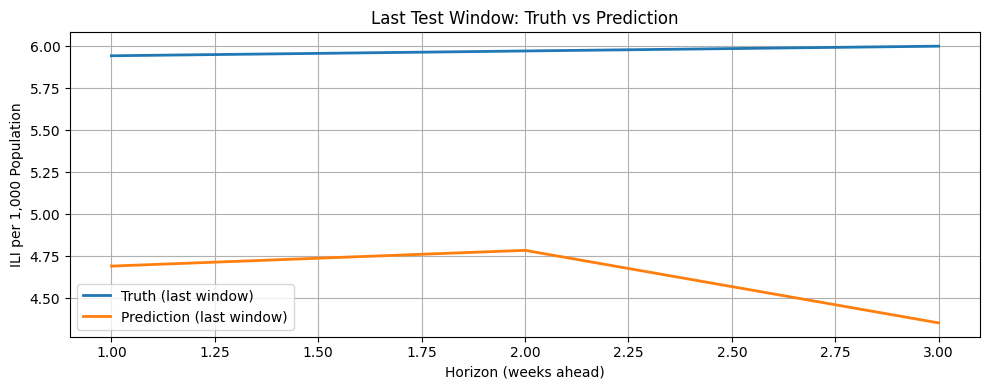

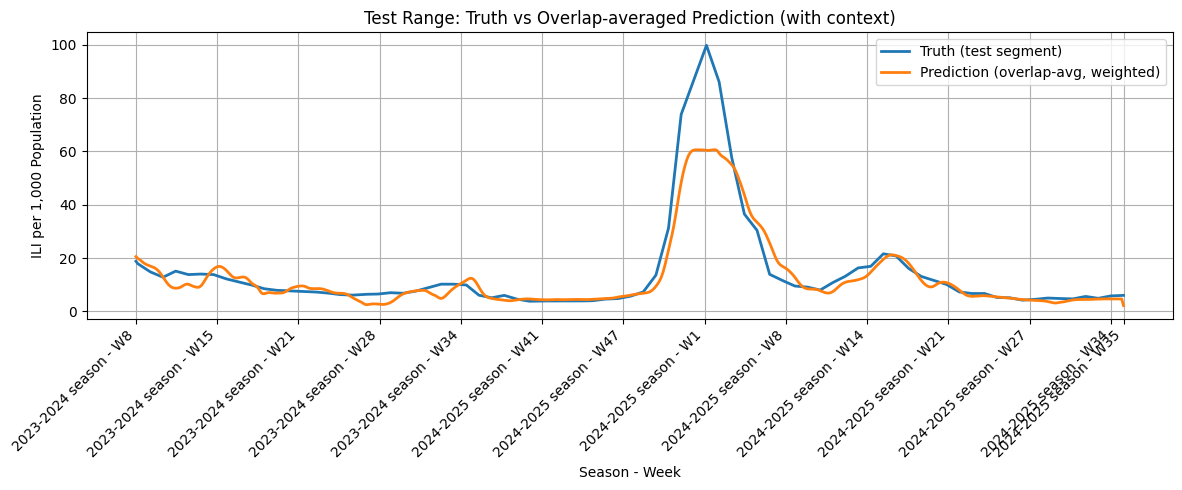

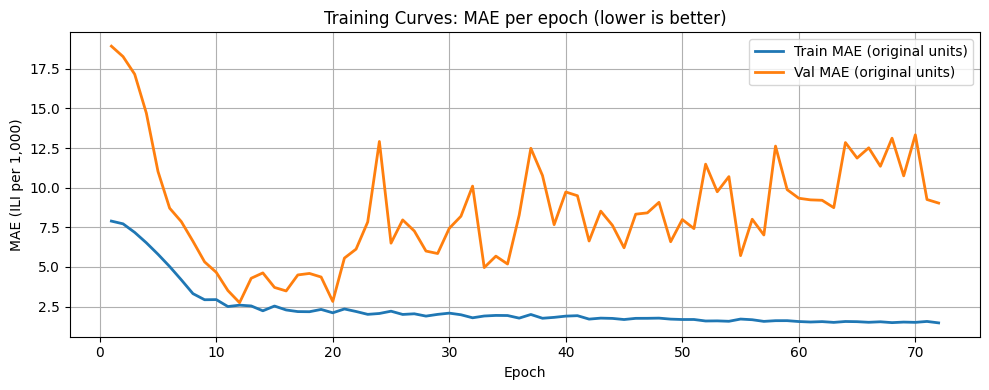

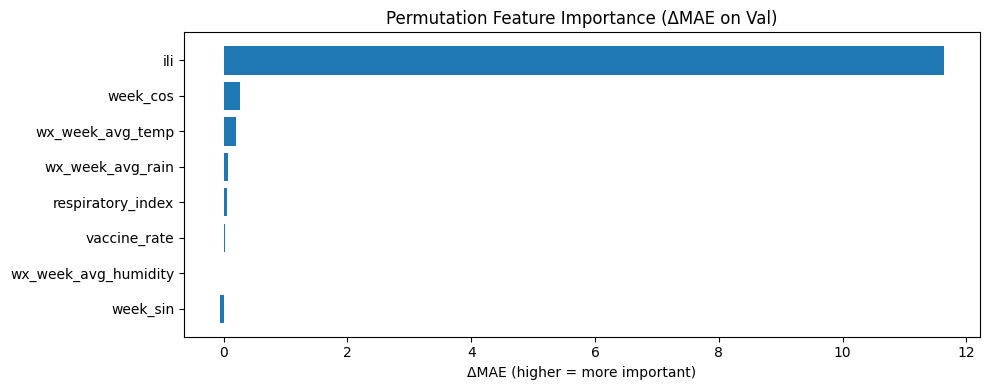

In [ ]:
# =========================
# Feature Importance utils
# =========================
def _eval_mae_on_split(model, X_split_sc, y_split_sc, scaler_y, feat_names, 
                       seq_len=SEQ_LEN, pred_len=PRED_LEN, patch_len=PATCH_LEN, stride=STRIDE,
                       batch_size=BATCH_SIZE):
    """현재 모델로 한 분할(va/test) 세트에서 MAE(원 단위) 계산"""
    ds = PatchTSTDataset(X_split_sc, y_split_sc, seq_len, pred_len, patch_len, stride)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    model.eval()
    mae_sum, n = 0.0, 0
    with torch.no_grad():
        for Xb, yb, _ in dl:
            Xb = Xb.to(DEVICE); yb = yb.to(DEVICE)
            pred = model(Xb)  # (B, H)
            mae_sum += batch_mae_in_original_units(pred, yb, scaler_y) * yb.size(0)
            n += yb.size(0)
    return float(mae_sum / max(1, n))


def compute_feature_importance(model, 
                               X_va_sc, y_va_sc, 
                               X_te_sc=None, y_te_sc=None,
                               scaler_y=None, feat_names=None, 
                               random_state=42):
    """
    퍼뮤테이션(열 섞기) 중요도와 평균 대체(그 특징을 평균으로 고정) 중요도를 계산.
    반환: 중요도 DataFrame (ΔMAE가 클수록 중요)
    """
    assert scaler_y is not None and feat_names is not None
    rng = np.random.RandomState(random_state)

    # --- 기준선(baseline MAE) ---
    baseline_val = _eval_mae_on_split(model, X_va_sc, y_va_sc, scaler_y, feat_names)
    print(f"[FI] Baseline Val MAE: {baseline_val:.6f}")

    baseline_tst = None
    if X_te_sc is not None and y_te_sc is not None:
        baseline_tst = _eval_mae_on_split(model, X_te_sc, y_te_sc, scaler_y, feat_names)
        print(f"[FI] Baseline Test MAE: {baseline_tst:.6f}")

    perm_deltas_val, mean_deltas_val = [], []
    perm_deltas_tst, mean_deltas_tst = [], []

    for j, name in enumerate(feat_names):
        # ① 퍼뮤테이션(열 섞기)
        Xp = X_va_sc.copy()
        col = Xp[:, j].copy()
        rng.shuffle(col)
        Xp[:, j] = col
        mae_perm_val = _eval_mae_on_split(model, Xp, y_va_sc, scaler_y, feat_names)
        perm_deltas_val.append(mae_perm_val - baseline_val)

        # ② 평균 대체(특징 제거 효과)
        Xz = X_va_sc.copy()
        Xz[:, j] = X_va_sc[:, j].mean()
        mae_mean_val = _eval_mae_on_split(model, Xz, y_va_sc, scaler_y, feat_names)
        mean_deltas_val.append(mae_mean_val - baseline_val)

        if X_te_sc is not None and y_te_sc is not None:
            Xp_te = X_te_sc.copy()
            col_te = Xp_te[:, j].copy()
            rng.shuffle(col_te)
            Xp_te[:, j] = col_te
            mae_perm_tst = _eval_mae_on_split(model, Xp_te, y_te_sc, scaler_y, feat_names)
            perm_deltas_tst.append(mae_perm_tst - baseline_tst)

            Xz_te = X_te_sc.copy()
            Xz_te[:, j] = X_te_sc[:, j].mean()
            mae_mean_tst = _eval_mae_on_split(model, Xz_te, y_te_sc, scaler_y, feat_names)
            mean_deltas_tst.append(mae_mean_tst - baseline_tst)

        print(f"[FI] {name:>20s} | ΔMAE(val) perm={perm_deltas_val[-1]:+.6f}  mean={mean_deltas_val[-1]:+.6f}")

    df = pd.DataFrame({
        "feature": feat_names,
        "delta_mae_val_perm": perm_deltas_val,
        "delta_mae_val_mean": mean_deltas_val,
    })
    if baseline_tst is not None:
        df["delta_mae_test_perm"] = perm_deltas_tst
        df["delta_mae_test_mean"] = mean_deltas_tst

    # ΔMAE가 클수록 중요 → 내림차순 정렬
    df = df.sort_values("delta_mae_val_perm", ascending=False).reset_index(drop=True)
    return df


def save_feature_importance(df: pd.DataFrame, out_csv="feature_importance.csv", out_png="feature_importance.png"):
    """중요도 테이블 저장 + 막대 그래프 저장"""
    df.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print(f"[FI] Saved -> {out_csv}")

    top = min(20, len(df))
    plt.figure(figsize=(10, max(4, 0.4*top)))
    plt.barh(df["feature"][:top][::-1], df["delta_mae_val_perm"][:top][::-1])
    plt.title("Permutation Feature Importance (ΔMAE on Val)")
    plt.xlabel("ΔMAE (higher = more important)")
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    print(f"[FI] Saved -> {out_png}")


# =========================
# train & evaluate (WITH Feature Importance)
# =========================
def train_and_eval(X: np.ndarray, y: np.ndarray, labels: list, feat_names: list,
                   compute_fi: bool = True, save_fi: bool = True):
    """
    X: (N,F), y: (N,), feat_names: ['ili', 'vaccine_rate', 'respiratory_index', ...]
    compute_fi: True면 검증/테스트 기반 피처 중요도 계산 및 저장
    save_fi: True면 feature_importance.csv/png 저장
    반환: (model, X_va_sc, y_va_sc, X_te_sc, y_te_sc, scaler_y, feat_names, fi_df)
    """
    set_seed(SEED)
    (s0,e0),(s1,e1),(s2,e2) = make_splits(len(y))
    X_tr, X_va, X_te = X[s0:e0], X[s1:e1], X[s2:e2]
    y_tr, y_va, y_te = y[s0:e0], y[s1:e1], y[s2:e2]
    lab_tr, lab_va, lab_te = labels[s0:e0], labels[s1:e1], labels[s2:e2]

    # ==== Scaling ====
    scaler_y = get_scaler()
    y_tr_sc = scaler_y.fit_transform(y_tr.reshape(-1,1)).ravel()
    y_va_sc = scaler_y.transform(y_va.reshape(-1,1)).ravel()
    y_te_sc = scaler_y.transform(y_te.reshape(-1,1)).ravel()

    scaler_x = get_scaler()
    X_tr_sc = scaler_x.fit_transform(X_tr)
    X_va_sc = scaler_x.transform(X_va)
    X_te_sc = scaler_x.transform(X_te)

    F = X.shape[1]
    print(f"[Shapes] X_tr:{X_tr.shape}, X_va:{X_va.shape}, X_te:{X_te.shape} | F={F}")
    print(f"[Info] Model input feature order -> {feat_names}")

    ds_tr = PatchTSTDataset(X_tr_sc, y_tr_sc, SEQ_LEN, PRED_LEN, PATCH_LEN, STRIDE)
    ds_va = PatchTSTDataset(X_va_sc, y_va_sc, SEQ_LEN, PRED_LEN, PATCH_LEN, STRIDE)
    ds_te = PatchTSTDataset(X_te_sc, y_te_sc, SEQ_LEN, PRED_LEN, PATCH_LEN, STRIDE)

    dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False)
    dl_te = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False)

    model = PatchTSTModel(
        in_features=F, patch_len=PATCH_LEN, d_model=D_MODEL, n_heads=N_HEADS,
        n_layers=ENC_LAYERS, ff_dim=FF_DIM, dropout=DROPOUT,
        pred_len=PRED_LEN, head_hidden=HEAD_HIDDEN
    ).to(DEVICE)

    crit = nn.HuberLoss(delta=1.0)
    opt  = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS, eta_min=1e-5)

    hist = {"train_loss":[], "val_loss":[], "train_mae":[], "val_mae":[]}

    best_val = float("inf"); best_state=None; noimp=0
    printed_batch_info = False
    for ep in range(1, EPOCHS+1):
        model.train(); tr_loss_sum=0; tr_mae_sum=0; n=0
        for g in opt.param_groups:
            g['lr'] = warmup_lr(ep, LR, WARMUP_EPOCHS)

        for Xb,yb,_ in dl_tr:
            if not printed_batch_info:
                print(f"[Batch] Xb.shape={tuple(Xb.shape)} (B,P,L,F), yb.shape={tuple(yb.shape)}")
                print(f"[Batch] Feature order used -> {feat_names}")
                printed_batch_info = True
            Xb=Xb.to(DEVICE); yb=yb.to(DEVICE)
            opt.zero_grad()
            pred = model(Xb)
            loss = crit(pred, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            bs=yb.size(0)
            tr_loss_sum += loss.item()*bs; n+=bs
            tr_mae_sum  += batch_mae_in_original_units(pred, yb, scaler_y)*bs

        tr_loss = tr_loss_sum / max(1,n)
        tr_mae  = tr_mae_sum  / max(1,n)

        model.eval(); va_loss_sum=0; va_mae_sum=0; va_corr_sum=0; n=0
        with torch.no_grad():
            for Xb,yb,_ in dl_va:
                Xb=Xb.to(DEVICE); yb=yb.to(DEVICE)
                pred = model(Xb); loss = crit(pred,yb)
                bs=yb.size(0)
                va_loss_sum += loss.item()*bs; n+=bs
                va_mae_sum  += batch_mae_in_original_units(pred, yb, scaler_y)*bs
                va_corr_sum += batch_corrcoef(pred, yb, scaler_y)*bs
        va_loss = va_loss_sum / max(1,n)
        va_mae  = va_mae_sum  / max(1,n)
        va_corr = va_corr_sum / max(1,n)

        scheduler.step()

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["train_mae"].append(tr_mae)
        hist["val_mae"].append(va_mae)

        print(f"[Epoch {ep:03d}/{EPOCHS}] "
              f"LR={opt.param_groups[0]['lr']:.6f} | "
              f"Loss T/V={tr_loss:.5f}/{va_loss:.5f} | "
              f"MAE  T/V={tr_mae:.5f}/{va_mae:.5f}"
              f"Corr V={va_corr:.3f}")

        if va_loss < best_val - 1e-6:
            best_val = va_loss; noimp=0
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
        else:
            noimp += 1
            if noimp >= PATIENCE:
                print(f"Early stopping after {ep} epochs (no improvement {PATIENCE}).")
                break

    if best_state is not None:
        model.load_state_dict({k:v.to(DEVICE) for k,v in best_state.items()})

    # ---- Test & Metrics ----
    model.eval(); preds=[]; trues=[]; starts=[]
    with torch.no_grad():
        for Xb,yb,i0 in dl_te:
            Xb=Xb.to(DEVICE)
            preds.append(model(Xb).detach().cpu().numpy())
            trues.append(yb.numpy())
            starts.append(i0.numpy())
    yhat_sc = np.concatenate(preds,axis=0)
    ytrue_sc= np.concatenate(trues,axis=0)
    starts  = np.concatenate(starts,axis=0)

    yhat  = scaler_y.inverse_transform(yhat_sc.reshape(-1,1)).reshape(-1,PRED_LEN)
    ytrue = scaler_y.inverse_transform(ytrue_sc.reshape(-1,1)).reshape(-1,PRED_LEN)

    mse  = float(np.mean((yhat-ytrue)**2))
    rmse = float(np.sqrt(mse))
    mae  = float(np.mean(np.abs(yhat-ytrue)))
    print("\n=== Final Test Metrics ===")
    print(f"MSE : {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE : {mae:.6f}")

    # =========================
    # Save per-window predictions
    # =========================
    cols_true = [f"true_t+{i}" for i in range(1,PRED_LEN+1)]
    cols_pred = [f"pred_t+{i}" for i in range(1,PRED_LEN+1)]
    out = pd.DataFrame(np.hstack([ytrue, yhat]), columns=cols_true+cols_pred)
    out.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
    print(f"Saved predictions -> {OUT_CSV}")

    # =========================
    # Plot_1: last window (H-step ahead)
    # =========================
    last_true = ytrue[-1]; last_pred = yhat[-1]
    weeks = np.arange(1, PRED_LEN+1)
    plt.figure(figsize=(10,4))
    plt.plot(weeks, last_true, label="Truth (last window)", linewidth=2)
    plt.plot(weeks, last_pred, label="Prediction (last window)", linewidth=2)
    plt.title("Last Test Window: Truth vs Prediction")
    plt.xlabel("Horizon (weeks ahead)")
    plt.ylabel("ILI per 1,000 Population")
    plt.grid(True); plt.legend()
    plt.tight_layout(); plt.savefig(PLOT_LAST_WINDOW, dpi=150)
    print(f"Saved plot -> {PLOT_LAST_WINDOW}")

    # =========================
    # Plot_2: test reconstruction (val-context included)
    # =========================
    context = y_va_sc[-SEQ_LEN:]
    y_ct_sc = np.concatenate([context, y_te_sc])              # [SEQ_LEN + test_len]
    X_ct_sc = np.concatenate([X_va_sc[-SEQ_LEN:], X_te_sc], axis=0)
    ds_ct = PatchTSTDataset(X_ct_sc, y_ct_sc, SEQ_LEN, PRED_LEN, PATCH_LEN, STRIDE)
    dl_ct = DataLoader(ds_ct, batch_size=BATCH_SIZE, shuffle=False)

    model.eval(); preds_ct=[]; starts_ct=[]
    with torch.no_grad():
        for Xb, _, i0 in dl_ct:
            Xb = Xb.to(DEVICE)
            preds_ct.append(model(Xb).detach().cpu().numpy())
            starts_ct.append(i0.numpy())
    yhat_ct_sc = np.concatenate(preds_ct, axis=0)
    starts_ct  = np.concatenate(starts_ct, axis=0)
    yhat_ct = scaler_y.inverse_transform(yhat_ct_sc.reshape(-1,1)).reshape(-1, PRED_LEN)

    test_len = len(y_te)
    recon_sum   = np.zeros(test_len)
    recon_count = np.zeros(test_len)
    h_weights = np.linspace(RECON_W_START, RECON_W_END, PRED_LEN)

    for k, s in enumerate(starts_ct):
        pos0_ct = int(s) + SEQ_LEN   # [context+test] 축
        pos0_te = pos0_ct - SEQ_LEN  # test 축으로 변환
        for j in range(PRED_LEN):
            idx = pos0_te + j
            if 0 <= idx < test_len:
                w = h_weights[j]
                recon_sum[idx]   += yhat_ct[k, j] * w
                recon_count[idx] += w

    recon = np.where(recon_count > 0, recon_sum / np.maximum(1, recon_count), np.nan)

    truth_test = y_te
    x_labels = lab_te
    tick_step = max(1, test_len // 12)
    tick_idx  = list(range(0, test_len, tick_step))
    if tick_idx[-1] != test_len-1:
        tick_idx.append(test_len-1)
    tick_text = [x_labels[i] for i in tick_idx]

    plt.figure(figsize=(12,5))
    plt.plot(range(test_len), truth_test, linewidth=2, label="Truth (test segment)")
    plt.plot(range(test_len), recon,      linewidth=2, label="Prediction (overlap-avg, weighted)")
    plt.title("Test Range: Truth vs Overlap-averaged Prediction (with context)")
    plt.xlabel("Season - Week"); plt.ylabel("ILI per 1,000 Population")
    plt.xticks(tick_idx, tick_text, rotation=45, ha="right")
    plt.grid(True); plt.legend()
    plt.tight_layout(); plt.savefig(PLOT_TEST_RECON, dpi=150)
    print(f"Saved plot -> {PLOT_TEST_RECON}")

    # =========================
    # Plot_3: Train/Val MAE curves
    # =========================
    xs = np.arange(1, len(hist["train_mae"])+1)
    plt.figure(figsize=(10,4))
    plt.plot(xs, hist["train_mae"], linewidth=2, label="Train MAE (original units)")
    plt.plot(xs, hist["val_mae"],   linewidth=2, label="Val MAE (original units)")
    plt.title("Training Curves: MAE per epoch (lower is better)")
    plt.xlabel("Epoch")
    plt.ylabel("MAE (ILI per 1,000)")
    plt.grid(True); plt.legend()
    plt.tight_layout(); plt.savefig(PLOT_MA_CURVES, dpi=150)
    print(f"Saved plot -> {PLOT_MA_CURVES}")

    # =========================
    # Feature Importance
    # =========================
    fi_df = None
    if compute_fi:
        fi_df = compute_feature_importance(
            model,
            X_va_sc, y_va_sc,
            X_te_sc, y_te_sc,
            scaler_y=scaler_y,
            feat_names=feat_names,
            random_state=SEED
        )
        if save_fi:
            save_feature_importance(
                fi_df,
                out_csv=str(BASE_DIR / "feature_importance.csv"),
                out_png=str(BASE_DIR / "feature_importance.png")
            )

    # 반환: 외부 셀에서 재활용 가능하도록
    return model, X_va_sc, y_va_sc, X_te_sc, y_te_sc, scaler_y, feat_names, fi_df

# =========================
# 실행부 (결과 출력)
# =========================
if __name__ == "__main__":
    model, X_va_sc, y_va_sc, X_te_sc, y_te_sc, scaler_y, feat_names, fi_df = train_and_eval(
        X, y, labels, feat_names,
        compute_fi=True,
        save_fi=True
    )

    print("\n=== [결과 요약] ===")
    print(f"Feature 개수: {len(feat_names)}")
    if fi_df is not None:
        print("\n[Top 10 Feature Importance]")
        print(fi_df.head(10).to_string(index=False))
    else:
        print("Feature Importance 계산이 수행되지 않았습니다.")